In [ ]:
## This script analyses a dataset for 72 (55 after NA removal) people who underwent in-clinic fasting, only baseline (before fasting) samples were collected. The samples were sequences using marker gene 16S rRNA sequeencing, not shot-gun sequencing like the other 2 datasets (Ducarmon and Grundler). I call this dataset '16S dataset'.

## Prepare data to calculate BMI Change and calculate it

import pandas as pd

# Load CSV file
df = pd.read_csv("3d ds 16S clin data.csv", parse_dates=["datetime"])

# For safety, sort by case_id and datetime
df = df.sort_values(["case_id", "datetime"])

# Filter to keep only case_ids that have a non-null height
valid_cases = df.dropna(subset=["height [cm]"])["case_id"].unique()
df_filtered = df[df["case_id"].isin(valid_cases)]

# Group by case_id and get first and last non-null weight rows
first_weights = df.groupby("case_id").first().reset_index()
last_weights = df.groupby("case_id").apply(lambda x: x.dropna(subset=["weight [kg]"]).iloc[-1]).reset_index(drop=True)

# Combine them
combined = pd.concat([first_weights, last_weights])

# Remove duplicates (in case first and last are the same row)
result = combined.drop_duplicates(subset=["case_id", "datetime"])

# Add suffixes to distinguish columns
wide_format = pd.merge(
    first_weights, 
    last_weights, 
    on="case_id", 
    suffixes=("_first", "_last")
)

# Get the case_ids present in both first and last weight sets
valid_case_ids = set(first_weights["case_id"]) & set(last_weights["case_id"])

# Filter both dataframes to keep only valid case_ids
first_weights_filtered = first_weights[first_weights["case_id"].isin(valid_case_ids)]
last_weights_filtered = last_weights[last_weights["case_id"].isin(valid_case_ids)]
# Merge into one row per case_id
wide_filtered = pd.merge(
    first_weights_filtered,
    last_weights_filtered,
    on="case_id",
    suffixes=("_first", "_last")
)

# Strip time part, convert to just date, and subtract directly
wide_filtered["fasting_days"] = (
    wide_filtered["datetime_last"].dt.date - wide_filtered["datetime_first"].dt.date
).apply(lambda x: x.days)

# Keep only necessary columns
result = wide_filtered[[
    "case_id",
    "height [cm]_first",         # assuming height is stored with _first suffix
    "weight [kg]_first",
    "weight [kg]_last","fasting_days"
]]

result = result.rename(columns={
    "height [cm]_first": "height_cm",
    "weight [kg]_first": "weight_before",
    "weight [kg]_last": "weight_after"
})

result = result.dropna(subset=["height_cm"])

# Convert height from cm to meters
height_m = result["height_cm"] / 100

# Calculate BMI_before and BMI_after
result["BMI_before"] = result["weight_before"] / (height_m ** 2)
result["BMI_after"] = result["weight_after"] / (height_m ** 2)

# Calculate absolute and percent change in BMI
result["BMI_change"] = result["BMI_after"] - result["BMI_before"]
result["BMI_change_percent"] = 100 * (result["BMI_change"] / result["BMI_before"])

result
#result.to_csv("bmi_results.csv", index=False)

C:\Users\akuro\AppData\Local\Temp\ipykernel_924\1456536252.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_weights = df.groupby("case_id").apply(lambda x: x.dropna(subset=["weight [kg]"]).iloc[-1]).reset_index(drop=True)


,case_id,height_cm,weight_before,weight_after,fasting_days,BMI_before,BMI_after,BMI_change,BMI_change_percent
0,428421,168.0,61.6,57.3,15,21.825397,20.301871,-1.523526,-6.980519
1,428758,177.0,84.8,80.7,8,27.067573,25.758882,-1.308692,-4.834906
2,428760,165.0,67.1,64.7,8,24.646465,23.764922,-0.881543,-3.576751
3,429145,182.0,78.9,73.6,14,23.819587,22.219539,-1.600048,-6.717364
4,429163,159.0,64.5,75.0,13,25.513231,29.666548,4.153317,16.279070
...,...,...,...,...,...,...,...,...,...
63,434369,178.0,100.6,92.5,26,31.751042,29.194546,-2.556495,-8.051690
64,434372,172.0,69.7,65.6,12,23.560032,22.174148,-1.385884,-5.882353
66,434512,177.0,115.8,103.2,20,36.962559,32.940726,-4.021833,-10.880829
68,434787,178.0,72.2,68.4,8,22.787527,21.588183,-1.199344,-5.263158


In [3]:
## Prepare 19 microbiome features to use in RF classifier

# Load CSV and treat "null" strings as missing (NaN)
df = pd.read_csv("metadata.csv", na_values=["null"])

# Now filter rows with non-missing result values
df_analyses = df[df["result"].notna()]

# Select relevant columns
df_analyses = df_analyses[["case_id", "description_analysis", "units", "result"]]
df_analyses

,case_id,description_analysis,units,result
0,430368,pH value,kA,7
1,430368,Actinobacteria,%,3
2,430368,Fusobacteriota,%,<0.0001
4,430368,Eubacterium spp.,%,2
7,430368,Desulvovibrio spp.,%,0.6
...,...,...,...,...
2977,434199,Blautia spp.,%,0.5
2978,434199,Roseburia spp.,%,1
2979,434199,Faecalibacterium spp.,%,15
2980,434199,Klebsiella spp.,%,<0.0001


In [4]:
# Create a pivot table with one row per case_id and one column per analysis
pivot = df_analyses.pivot_table(
    index="case_id",
    columns="description_analysis",
    values="result",
    aggfunc="first"
)

# Calculate % of non-null entries per analysis
valid_fraction = pivot.notna().mean()

# Keep only analyses with at least 80% non-null results
selected_analyses = valid_fraction[valid_fraction >= 0.8].index

# Filter original dataframe to keep only those analyses
df_filtered = df_analyses[df_analyses["description_analysis"].isin(selected_analyses)]
df_filtered

,case_id,description_analysis,units,result
1,430368,Actinobacteria,%,3
2,430368,Fusobacteriota,%,<0.0001
4,430368,Eubacterium spp.,%,2
7,430368,Desulvovibrio spp.,%,0.6
9,430368,Bacteroidetes (Bacteroidota),%,16
...,...,...,...,...
2976,434199,Eubacterium spp.,%,1
2977,434199,Blautia spp.,%,0.5
2978,434199,Roseburia spp.,%,1
2979,434199,Faecalibacterium spp.,%,15


In [ ]:
# Replace string "<0.0001" with 0, then ensure column is numeric
df_filtered["result"] = df_filtered["result"].replace("<0.0001", 0)
df_filtered["result"] = pd.to_numeric(df_filtered["result"], errors="coerce")

In [ ]:
# Are the features normally distributed?
# According to histograms bellow - No. Then,to capture a non-linear relationship, let's use a RF classifier instead of a linear regression. Also, classifiers can be more powerful.

import matplotlib.pyplot as plt

# Loop through each unique description_analysis
for analysis in df_filtered["description_analysis"].unique():
    subset = df_filtered[df_filtered["description_analysis"] == analysis]
    
    # Try to convert result to numeric (skip non-numeric)
    try:
        numeric_results = pd.to_numeric(subset["result"], errors="coerce").dropna()
        if len(numeric_results) < 2:
            continue  # Skip if too few numeric values
        
        plt.figure(figsize=(6, 4))
        plt.hist(numeric_results, bins=20, color="skyblue", edgecolor="black")
        plt.title(f"Histogram of '{analysis}' results")
        plt.xlabel("Result")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Skipping {analysis}: {e}")

In [ ]:
## Create a dataframe for RF model, call it df_rf. Dataframe columns: case_id, 19 microbiome features, BMI_change_percent (as positive value).

## Note! The script above does not produce correct numbers of fasting days for all case ids. So I went through data manually to correct number of fasting days for case ids: 431553, 432500, 432795, 433985, 434199. Also, I removed rows for ids 433130 and 433148 as the original metadata file probably contains errors for these participants.
## The corrected file is bmi_results_adj_fast_days.csv (in data folder)
## This data correction leads to slightly different results of RF accuracy metrics, without a significant change.

# 1. Load the (corrected) BMI results CSV
bmi_df = pd.read_csv("bmi_results_adj_fast_days.csv")
#bmi_df = pd.read_csv("bmi_results.csv")

# 2. Keep only case_ids present in bmi_df
df_filtered_subset = df_filtered[df_filtered["case_id"].isin(bmi_df["case_id"])]

# 3. Merge to include BMI_change_percent
merged_df = pd.merge(
    df_filtered_subset,
    bmi_df[["case_id", "BMI_change_percent"]],
    on="case_id",
    how="inner"  # Ensures only matching case_ids are kept
)

print(merged_df["case_id"].nunique())

merged_df["BMI_change_percent"] = -merged_df["BMI_change_percent"]

print(merged_df["description_analysis"].nunique())

merged_df

62
19


,case_id,description_analysis,units,result,BMI_change_percent
0,430368,Actinobacteria,%,3.0,5.616606
1,430368,Fusobacteriota,%,0.0,5.616606
2,430368,Eubacterium spp.,%,2.0,5.616606
3,430368,Desulvovibrio spp.,%,0.6,5.616606
4,430368,Bacteroidetes (Bacteroidota),%,16.0,5.616606
...,...,...,...,...,...
1171,434199,Eubacterium spp.,%,1.0,2.079395
1172,434199,Blautia spp.,%,0.5,2.079395
1173,434199,Roseburia spp.,%,1.0,2.079395
1174,434199,Faecalibacterium spp.,%,15.0,2.079395


In [ ]:
# 1. Pivot to wide format with raw result values
pivot_df = merged_df.pivot_table(
    index="case_id",
    columns="description_analysis",
    values="result",  # <- use raw 'result' here
    aggfunc="first"
)

# 2. Add BMI_change_percent target
targets = merged_df.drop_duplicates(subset="case_id")[["case_id", "BMI_change_percent"]]
df_rf = pivot_df.merge(targets.set_index("case_id"), left_index=True, right_index=True)

# 3. Drop rows with missing values
df_rf = df_rf.dropna()

df_rf

,Actinobacteria,Akkermansia muciniphila,Bacteroides spp.,Bacteroidetes (Bacteroidota),Bifidobacterium spp.,Blautia spp.,Desulvovibrio spp.,Escherichia spp.,Eubacterium spp.,Faecalibacterium spp.,Firmicutes (Bacillota),Firmicutes/Bacteroidetes-Ratio,Fusobacteriota,Klebsiella spp.,Lactobacillus,Prevotella spp.,Proteobacteria(Pseudomonadota),Roseburia spp.,Verrucomicrobiota,BMI_change_percent
case_id,,,,,,,,,,,,,,,,,,,,
428421,1.0,0.300,8.000,25.0,0.250,0.70,0.000,6.000,0.80,7.000,65.0,3.0,0.000,0.000,0.200,0.000,8.00,3.00,0.300,6.980519
428758,4.0,0.035,0.500,7.0,2.000,1.00,0.050,0.056,8.00,3.000,88.0,12.0,0.000,0.000,0.400,3.000,0.20,8.00,0.037,4.834906
428760,3.0,1.000,7.000,8.0,0.290,2.00,0.000,14.000,2.00,10.000,70.0,9.0,0.003,2.000,0.300,0.200,18.00,3.00,1.000,3.576751
429145,0.3,1.000,2.000,4.0,0.006,3.00,0.000,0.008,6.00,0.900,91.0,22.0,0.000,0.000,0.059,0.002,0.30,8.00,4.000,6.717364
429163,3.0,0.000,7.000,9.0,0.000,18.00,0.000,2.000,0.40,3.000,78.0,9.0,0.000,0.000,0.000,0.028,10.00,0.20,0.000,7.286822
429653,3.0,0.000,7.000,13.0,2.000,3.00,0.000,0.100,2.00,17.000,84.0,7.0,0.000,0.000,0.000,0.000,0.30,6.00,0.000,7.169811
429683,3.0,12.000,9.000,17.0,0.790,0.60,0.000,0.024,2.00,3.000,67.0,4.0,0.000,0.000,0.300,0.000,0.40,5.00,12.000,3.174603
429721,3.0,9.000,19.000,38.0,0.000,0.50,0.016,0.300,0.50,0.600,37.0,1.0,0.000,0.001,0.036,0.000,1.00,0.20,19.000,5.719237
430256,0.9,0.200,2.000,5.0,0.048,7.00,0.000,1.000,5.00,9.000,92.0,18.0,0.000,0.000,0.031,0.007,1.00,3.00,0.200,8.058124


In [19]:
# Add responder / non-responder label to each case id

# Compute median of BMI_change_percent
median_bmi_change = df_rf["BMI_change_percent"].median()

# Create binary target variable
df_rf["responder_label"] = df_rf["BMI_change_percent"].apply(
    lambda x: "non-responder" if x < median_bmi_change else "responder"
)

In [22]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

# Features and binary labels
X = df_rf.drop(columns=["BMI_change_percent", "responder_label"])
y = df_rf["responder_label"]

# Optional: stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [23]:
# Train RF classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [24]:
# Test the classifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

y_pred = clf.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("ROC AUC score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

Accuracy: 0.5
Confusion matrix:
 [[4 5]
 [4 5]]
Classification report:
                precision    recall  f1-score   support

non-responder       0.50      0.44      0.47         9
    responder       0.50      0.56      0.53         9

     accuracy                           0.50        18
    macro avg       0.50      0.50      0.50        18
 weighted avg       0.50      0.50      0.50        18

ROC AUC score: 0.4814814814814815


In [25]:
# Get feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
top5_features = feature_importances.sort_values(ascending=False).head(5)
print("Top 5 most important features:\n", top5_features)

Top 5 most important features:
 Bacteroides spp.           0.116100
Lactobacillus              0.108370
Akkermansia muciniphila    0.077047
Faecalibacterium spp.      0.069401
Firmicutes (Bacillota)     0.056160
dtype: float64


In [26]:
## Let's adjust BMI_change_percent for the number of fasting days (different among participants)

# Merge fasting_days from bmi_df into df_rf
df_rf = pd.merge(
    df_rf,
    bmi_df[["case_id", "fasting_days"]],
    on="case_id",
    how="left"
)

In [27]:
df_rf = df_rf.drop(columns=["responder_label"])

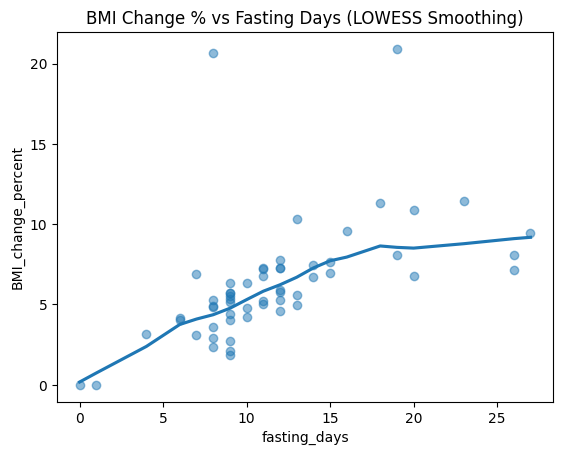

In [28]:
# How does correlation between BMI_change_percent and number of fasting_days look?
# Square root shape?

import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x="fasting_days", y="BMI_change_percent", data=df_rf, lowess=True, scatter_kws={'alpha':0.5})
plt.title("BMI Change % vs Fasting Days (LOWESS Smoothing)")
plt.show()

In [29]:
import numpy as np
import statsmodels.api as sm

# 1. Create a new column: square root of fasting_days
df_rf["fasting_days_sqrt"] = np.sqrt(df_rf["fasting_days"])

# 2. Build design matrix with intercept, fasting_days and its square root
X_poly = sm.add_constant(df_rf[[ "fasting_days_sqrt"]])

# 3. Fit OLS model
model = sm.OLS(df_rf["BMI_change_percent"], X_poly).fit()

# 4. Get residuals (BMI change adjusted for fasting_days and its square root)
df_rf["BMI_change_residual"] = model.resid

In [30]:
model.params

const               -1.579687
fasting_days_sqrt    2.380281
dtype: float64

In [31]:
## In the adjusted model, "BMI_change_residual" becomes the variable that defines responder label

# Use median of residuals to re-define responders/non-responders
median_resid = df_rf["BMI_change_residual"].median()
df_rf["responder_label"] = df_rf["BMI_change_residual"].apply(
    lambda x: "non-responder" if x < median_resid else "responder"
)

In [32]:
df_rf

,case_id,Actinobacteria,Akkermansia muciniphila,Bacteroides spp.,Bacteroidetes (Bacteroidota),Bifidobacterium spp.,Blautia spp.,Desulvovibrio spp.,Escherichia spp.,Eubacterium spp.,...,Lactobacillus,Prevotella spp.,Proteobacteria(Pseudomonadota),Roseburia spp.,Verrucomicrobiota,BMI_change_percent,fasting_days,fasting_days_sqrt,BMI_change_residual,responder_label
0,428421,1.0,0.300,8.000,25.0,0.250,0.70,0.000,6.000,0.80,...,0.200,0.000,8.00,3.00,0.300,6.980519,15,3.872983,-0.658583,non-responder
1,428758,4.0,0.035,0.500,7.0,2.000,1.00,0.050,0.056,8.00,...,0.400,3.000,0.20,8.00,0.037,4.834906,8,2.828427,-0.317859,responder
2,428760,3.0,1.000,7.000,8.0,0.290,2.00,0.000,14.000,2.00,...,0.300,0.200,18.00,3.00,1.000,3.576751,8,2.828427,-1.576013,non-responder
3,429145,0.3,1.000,2.000,4.0,0.006,3.00,0.000,0.008,6.00,...,0.059,0.002,0.30,8.00,4.000,6.717364,14,3.741657,-0.609146,non-responder
4,429163,3.0,0.000,7.000,9.0,0.000,18.00,0.000,2.000,0.40,...,0.000,0.028,10.00,0.20,0.000,7.286822,12,3.464102,0.620973,responder
5,429653,3.0,0.000,7.000,13.0,2.000,3.00,0.000,0.100,2.00,...,0.000,0.000,0.30,6.00,0.000,7.169811,26,5.099020,-3.387602,non-responder
6,429683,3.0,12.000,9.000,17.0,0.790,0.60,0.000,0.024,2.00,...,0.300,0.000,0.40,5.00,12.000,3.174603,4,2.000000,-0.006272,responder
7,429721,3.0,9.000,19.000,38.0,0.000,0.50,0.016,0.300,0.50,...,0.036,0.000,1.00,0.20,19.000,5.719237,9,3.000000,0.158081,responder
8,430256,0.9,0.200,2.000,5.0,0.048,7.00,0.000,1.000,5.00,...,0.031,0.007,1.00,3.00,0.200,8.058124,19,4.358899,-0.737594,non-responder
9,430368,3.0,0.700,3.000,16.0,2.000,2.00,0.600,0.002,2.00,...,0.600,0.000,1.00,10.00,0.700,5.616606,13,3.605551,-1.385933,non-responder


In [33]:
## Repeat random forest

# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

# Features and binary labels
X = df_rf.drop(columns=["BMI_change_percent", "BMI_change_residual", "responder_label", "case_id", "fasting_days", "fasting_days_sqrt"])
y = df_rf["responder_label"]

# Optional: stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [34]:
# Train RF classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Test the classifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

y_pred = clf.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("ROC AUC score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

Accuracy: 0.4444444444444444
Confusion matrix:
 [[3 6]
 [4 5]]
Classification report:
                precision    recall  f1-score   support

non-responder       0.43      0.33      0.38         9
    responder       0.45      0.56      0.50         9

     accuracy                           0.44        18
    macro avg       0.44      0.44      0.44        18
 weighted avg       0.44      0.44      0.44        18

ROC AUC score: 0.4012345679012346
